<a href="https://colab.research.google.com/github/loisll/MMAI984/blob/main/lois_trainmodel_Team_Project_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install torch torchvision transformers
!pip install tqdm

STEP 1: Import libraries

In [105]:
# step 1: Import libraries
import pandas as pd
from PIL import Image
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import zipfile
from google.colab import drive
import random
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
import re
from tqdm import tqdm

In [106]:
# Define the data path
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STEP 2: LOAD TRAIN DATA

In [107]:
# Define function for loading questions and annotations

def load_data(data_file, feature):

  # Check if the file exists
  if os.path.exists(data_file):
    print("File found:", data_file)

    # Load the JSON file using the json module
    with open(data_file, 'r') as f:
        data = json.load(f)

    # Convert the JSON data to a DataFrame
    # questions = pd.DataFrame(data)

    # Flatten the JSON structure
    data = pd.json_normalize(data[feature])

    # Question preprocessing

    print("Data loaded successfully")
  else:
    print("File not found:", data_file)

  return data

*Load and prepare the training dataset*

In [108]:
# Load training questions

# Define the questions file
train_questions_file = os.path.join(data_path, 'train2015/MultipleChoice_abstract_v002_train2015_questions.json')
#train_questions_file = os.path.join(data_path)
train_questions_feature = 'questions'

train_questions = load_data(train_questions_file, train_questions_feature )

# Check the first 5 rows
train_questions

File found: /content/drive/My Drive/Colab Notebooks/train2015/MultipleChoice_abstract_v002_train2015_questions.json
Data loaded successfully


,image_id,question,multiple_choices,question_id
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791
3,5536,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",55360
4,5536,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",55361
...,...,...,...,...
59995,11695,What color is the log the little girl sitting on?,"[tan, brown, white, 1, running, red, 4, pink, ...",116950
59996,11695,Does the boy want to go on the seesaw?,"[red, no table, fetch, kicking soccer ball, ye...",116951
59997,13790,What animal is between the two men?,"[dog, 4, yellow, 1, collectors, no, red, yes, ...",137900
59998,13790,What food is by the picnic basket?,"[4, she is happy, grapes, pizza, white, becaus...",137901


In [109]:
# Load trainning annotations

# Define the annotations file
train_annotations_file = os.path.join(data_path, 'train2015/abstract_v002_train2015_annotations.json')
train_annotations_feature = 'annotations'
train_annotations = load_data(train_annotations_file, train_annotations_feature)

#print(train_annotations_file[annotations])
# Check the first 5 rows
train_annotations

File found: /content/drive/My Drive/Colab Notebooks/train2015/abstract_v002_train2015_annotations.json
Data loaded successfully


,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,who,man,"[{'answer': 'old person', 'answer_confidence':...",11779,other,117792
1,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",11779,other,117790
2,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",11779,other,117791
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",5536,yes/no,55360
4,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",5536,other,55361
...,...,...,...,...,...,...
59995,what color is the,brown,"[{'answer': 'brown', 'answer_confidence': 'yes...",11695,other,116950
59996,does the,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",11695,yes/no,116951
59997,what animal is,cat,"[{'answer': 'cat', 'answer_confidence': 'yes',...",13790,other,137900
59998,what,watermelon,"[{'answer': 'watermelon, sandwich, burger', 'a...",13790,other,137901


In [110]:

# Load trainning captions

# Define the annotations file
train_captions_file = os.path.join(data_path, 'train2015/captions_abstract_v002_train2015.json')
train_captions_feature = 'images'
train_captions = load_data(train_captions_file, train_captions_feature)

#print(train_captions_file[annotations])
# Check the first 5 rows
train_captions

File found: /content/drive/My Drive/Colab Notebooks/train2015/captions_abstract_v002_train2015.json
Data loaded successfully


,url,file_name,image_id,width,height
0,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000000000.png,0,700,400
1,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000000001.png,1,700,400
2,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000000002.png,2,700,400
3,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000000003.png,3,700,400
4,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000000004.png,4,700,400
...,...,...,...,...,...
19995,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000019995.png,19995,700,400
19996,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000019996.png,19996,700,400
19997,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000019997.png,19997,700,400
19998,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000019998.png,19998,700,400


In [111]:
# Load trainning captions

# Define the annotations file
train_OpenEnded_file = os.path.join(data_path, 'train2015/OpenEnded_abstract_v002_train2015_questions.json')
train_OpenEnded_feature = 'questions'
train_OpenEnded = load_data(train_OpenEnded_file, train_OpenEnded_feature)

#print(train_captions_file[annotations])
# Check the first 5 rows
train_OpenEnded

File found: /content/drive/My Drive/Colab Notebooks/train2015/OpenEnded_abstract_v002_train2015_questions.json
Data loaded successfully


,question,image_id,question_id
0,Who looks happier?,11779,117792
1,Where is the woman sitting?,11779,117790
2,Where is the man sitting?,11779,117791
3,Is this man hungry?,5536,55360
4,What kind of drink is that?,5536,55361
...,...,...,...
59995,What color is the log the little girl sitting on?,11695,116950
59996,Does the boy want to go on the seesaw?,11695,116951
59997,What animal is between the two men?,13790,137900
59998,What food is by the picnic basket?,13790,137901


2.2 MERGE TRAIN DATA

In [112]:
# Merge questions and answers

#train_data = pd.merge(train_questions, train_annotations, on='question_id')
train_data = pd.merge(train_questions, train_annotations, on=["image_id", "question_id"])

df_train = train_data.merge(train_captions, on='image_id')
df_train

,image_id,question,multiple_choices,question_id,question_type,multiple_choice_answer,answers,answer_type,url,file_name,width,height
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792,who,man,"[{'answer': 'old person', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
3,5536,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",55360,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400
4,5536,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",55361,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,11695,What color is the log the little girl sitting on?,"[tan, brown, white, 1, running, red, 4, pink, ...",116950,what color is the,brown,"[{'answer': 'brown', 'answer_confidence': 'yes...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011695.png,700,400
59996,11695,Does the boy want to go on the seesaw?,"[red, no table, fetch, kicking soccer ball, ye...",116951,does the,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011695.png,700,400
59997,13790,What animal is between the two men?,"[dog, 4, yellow, 1, collectors, no, red, yes, ...",137900,what animal is,cat,"[{'answer': 'cat', 'answer_confidence': 'yes',...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000013790.png,700,400
59998,13790,What food is by the picnic basket?,"[4, she is happy, grapes, pizza, white, becaus...",137901,what,watermelon,"[{'answer': 'watermelon, sandwich, burger', 'a...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000013790.png,700,400


**STEP 3 : EDA**

From the above examples, we can see that most of the questions and answers are simple and clean text but some questions contain punctuation, common word contractions like what’s, it’s, they’re, etc, and noun contractions like guy’s, man’s, dog’s, etc., and some answers also contain punctuation. Hence, we need to perform the data cleaning operation on the question and answer dataset and expand contractions before performing EDA.

In [113]:

def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)

    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9
    text = re.sub(' +', ' ', text) # remove extra space
    return text

# Question and Answer text preprocessing
df_train["question_preprocessed"] = df_train["question"].map(lambda x: text_preprocess(x))
df_train["answer_preprocessed"] = df_train["multiple_choice_answer"].map(lambda x: text_preprocess(x))

In [114]:
df_train

,image_id,question,multiple_choices,question_id,question_type,multiple_choice_answer,answers,answer_type,url,file_name,width,height,question_preprocessed,answer_preprocessed
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792,who,man,"[{'answer': 'old person', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,who looks happier,man
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,where is the woman sitting,blanket
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,where is the man sitting,bench
3,5536,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",55360,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400,is this man hungry,yes
4,5536,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",55361,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400,what kind of drink is that,soda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,11695,What color is the log the little girl sitting on?,"[tan, brown, white, 1, running, red, 4, pink, ...",116950,what color is the,brown,"[{'answer': 'brown', 'answer_confidence': 'yes...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011695.png,700,400,what color is the log the little girl sitting on,brown
59996,11695,Does the boy want to go on the seesaw?,"[red, no table, fetch, kicking soccer ball, ye...",116951,does the,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011695.png,700,400,does the boy want to go on the seesaw,yes
59997,13790,What animal is between the two men?,"[dog, 4, yellow, 1, collectors, no, red, yes, ...",137900,what animal is,cat,"[{'answer': 'cat', 'answer_confidence': 'yes',...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000013790.png,700,400,what animal is between the two men,cat
59998,13790,What food is by the picnic basket?,"[4, she is happy, grapes, pizza, white, becaus...",137901,what,watermelon,"[{'answer': 'watermelon, sandwich, burger', 'a...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000013790.png,700,400,what food is by the picnic basket,watermelon


In [ ]:
#create class label
one_hot_encoded_data = pd.get_dummies(data, columns = ['Remarks', 'Gender'])
print(one_hot_encoded_data)

# Preprocess the image


In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import nltk
import numpy as np
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing import image


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [146]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size of the model (if needed)
    transforms.ToTensor(),  # Convert image to PyTorch tensor and normalize values between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standardize using ImageNet statistics
])

def preprocess_image(image_path):
  image = Image.open(image_path).convert("RGB")  # Convert to RGB (in case it's grayscale or has transparency)
    # Preprocess the image
  image_tensor = preprocess(image)

  # Add batch dimension (if you are feeding the image into a model)
  image_tensor = image_tensor.unsqueeze(0)
  #image_tensor = img_to_array(image_tensor)
  return image_tensor

In [160]:
#defin the image path
extract_dir_test = os.path.join(data_path, 'train2015/train2015_images/test')

def image_encoder(extract_dir_test):
   for filename in os.listdir(extract_dir_test):
     if filename.endswith('.png'):
       image_path = os.path.join(extract_dir_test, filename)
       tensor_gpu=preprocess_image(image)
        #tensor_result.appen[tensor_gpu]
       return tensor_gpu



In [161]:
tensor_result=[]
for filename in os.listdir(extract_dir_test):
     # Check if the file is a PNG image
     if filename.endswith('.png'):
       # Create the full path to the image
        image_path = os.path.join(extract_dir_test, filename)
              # Open the image
        image = Image.open(image_path)
              # preprocessing image
        tensor_gpu=preprocess_image(image_path)
        array = tensor_gpu.numpy()
        tensor_result.append(array)


In [163]:
tensor_result.shape

AttributeError: 'list' object has no attribute 'shape'

In [81]:
vqa_dataset.shape

(1, 3, 224, 224)

In [35]:
stacked_tensor = torch.stack(tensor)

# Print the shape of the stacked tensor (it should be [5, 3, 224, 224])
print(f"Stacked tensor shape: {stacked_tensor.shape}")

# Step 3: Convert the stacked tensor to a NumPy array
numpy_array = stacked_tensor.numpy()

# Print the shape of the resulting NumPy array (it should match the tensor shape)
print(f"NumPy array shape: {numpy_array.shape}")

Stacked tensor shape: torch.Size([18, 1, 3, 224, 224])
NumPy array shape: (18, 1, 3, 224, 224)


In [41]:
stacked_tensor[:-10].shape

torch.Size([8, 1, 3, 224, 224])

In [42]:
X_train, y_train = stacked_tensor[:-10], tensor[:-10]
X_valid, y_valid = tensor[-10:], tensor[-10:]

In [44]:
y_train

[tensor([[[[ 1.5297,  1.5297,  1.5297,  ...,  1.5297,  1.5297,  1.5297],
           [ 1.5297,  1.5297,  1.5297,  ...,  1.5297,  1.5297,  1.5297],
           [ 1.5125,  1.5125,  1.5125,  ...,  1.5125,  1.5125,  1.5125],
           ...,
           [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
           [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
           [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877]],
 
          [[ 2.3585,  2.3585,  2.3585,  ...,  2.3585,  2.3585,  2.3585],
           [ 2.3585,  2.3585,  2.3585,  ...,  2.3585,  2.3585,  2.3585],
           [ 2.3585,  2.3585,  2.3585,  ...,  2.3585,  2.3585,  2.3585],
           ...,
           [ 0.1352,  0.1352,  0.1352,  ...,  0.1352,  0.1352,  0.1352],
           [ 0.1352,  0.1352,  0.1352,  ...,  0.1352,  0.1352,  0.1352],
           [ 0.1352,  0.1352,  0.1352,  ...,  0.1352,  0.1352,  0.1352]],
 
          [[ 2.6226,  2.6226,  2.6226,  ...,  2.6226,  2.6226,  2.6226],
           [ 

3. build model


In [46]:
from tensorflow.keras import layers, models

# 创建 CNN 模型
model = models.Sequential()

# 第一层卷积和池化
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 第二层卷积和池化
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 第三层卷积和池化
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 第四层卷积和池化
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten层，用于将3D张量展平成1D张量
model.add(layers.Flatten())

# 全连接层
model.add(layers.Dense(512, activation='relu'))

# 输出层，假设有3个类别
model.add(layers.Dense(3, activation='softmax'))  # 3类多分类问题

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 8
'y' sizes: 1, 1, 1, 1, 1, 1, 1, 1


In [ ]:
# 评估模型
test_loss, test_acc = model.evaluate(tensor)
print(f"Test accuracy: {test_acc:.4f}")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 加载要预测的图像，并进行预处理
img_path = 'path_to_new_image'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)  # 添加batch维度
img_tensor /= 255.  # 归一化

# 进行预测
predictions = model.predict(img_tensor)

# 输出类别
print(f"Predicted class: {np.argmax(predictions)}")

In [60]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layer to get encoded feature vector
        self.fc = nn.Linear(32 * 56 * 56, 128)  # Change this based on input image size

    def forward(self, x):
        # Apply first convolution, ReLU, and pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolution, ReLU, and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output from the conv layers
        x = x.view(-1, 32 * 56 * 56)  # Flattening tensor

        # Pass through the fully connected layer to get the encoded vector
        encoded = self.fc(x)

        return encoded

In [61]:
# Initialize the CNN encoder
cnn_encoder = CNNEncoder()

# Encode the image
encoded_image = cnn_encoder(tensor)


NameError: name 'F' is not defined

In [ ]:
# def preprocess_image(file_path):
#     # Load and decode the image
#     #img = tf.io.read_file(file_path)
#     img = cv2.imread(data_path+"/train2015/train2015_images/" +image_path[1])
#     # You can adjust channels based on your images (3 for RGB)
#     img = tf.image.decode_png(img, channels=3) # Returned as uint8
#     # Normalize the pixel values to [0, 1]
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     # Resize the image to your desired dimensions
#     img = tf.image.resize(img, [96, 128], method = 'nearest')
#     return img


In [ ]:

def preprocess_target(file_path):
    # Load and decode the image
    mask = tf.io.read_file(file_path)
    # Normalizing to between 0 and 1 (only two classes)
    mask = tf.image.decode_image(mask, expand_animations=False, dtype=tf.float32)
    # Get only one value for the 3rd channel
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    # Resize the image to your desired dimensions
    mask = tf.image.resize(mask, [96, 128], method = 'nearest')
    return mask

def dice_coef(y_true, y_pred, smooth=10e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
        tf.keras.layers.RandomRotation(factor=0.01, seed=42),
        tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    mask = pred_mask[..., -1] >= 0.5
    pred_mask[..., -1] = tf.where(mask, 1, 0)
    # Return only first mask of batch
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset:
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Ensure reproducibility
import numpy as np
np.random.seed(0)
# Load the MNIST dataset
train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
train_target = mnist_train_set.train_labels
test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
test_target = mnist_test_set.test_labels


# Reshape the dataset to include a channel dimension (grayscale, so only 1 channel)
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Normalize the pixel values to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

AttributeError: 'DataFrame' object has no attribute 'mnist'

2 IMAGE ENCODER


In [ ]:
class VQADataset(Dataset):
    def __init__(self, img_dir, questions_file, answers_file, transform=None):
        self.img_dir = img_dir
        self.questions = open(questions_file).read().splitlines()
        self.answers = open(answers_file).read().splitlines()
        self.transform = transform

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question, image_name = self.questions[idx].split("\t")
        answer = self.answers[idx]

        img_path = f"{self.img_dir}/{image_name}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Tokenization for questions
def tokenize_question(question):
    return nltk.word_tokenize(question.lower())

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(VQAModel, self).__init__()

        # Image feature extractor (pretrained ResNet)
        resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last layer

         # Embedding layer for questions
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM for question processing
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        # Fully connected layers for combining image and question features
        self.fc1 = nn.Linear(2048 + hidden_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, image, question):
        # Image feature extraction
        img_features = self.resnet(image)
        img_features = img_features.view(img_features.size(0), -1)  # Flatten the output

        # Question feature extraction
        embedded = self.embedding(question)
        _, (hidden, _) = self.lstm(embedded)
        question_features = hidden[-1]  # Use the last hidden state of the LSTM

        # Combine image and question features
        combined = torch.cat((img_features, question_features), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)

        return x

In [ ]:
def train_vqa_model(model, train_loader, num_epochs, criterion, optimizer, device):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for images, questions, answers in train_loader:
            images, answers = images.to(device), answers.to(device)

            # Tokenize questions
            tokenized_questions = [torch.tensor(tokenize_question(q), dtype=torch.long) for q in questions]
            tokenized_questions = nn.utils.rnn.pad_sequence(tokenized_questions, batch_first=True).to(device)

            # Forward pass
            outputs = model(images, tokenized_questions)
            loss = criterion(outputs, answers)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

In [ ]:
# Hyperparameters
vocab_size = 10000   # Vocabulary size for questions
embed_size = 256     # Embedding size for questions
hidden_size = 512    # LSTM hidden size
num_classes = 1000   # Number of possible answers (e.g., top 1000 most frequent answers)
num_epochs = 5
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
model = VQAModel(vocab_size, embed_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create dataset and dataloader
#Edataset = VQADataset(img_dir='images', questions_file='questions.txt', answers_file='answers.txt', transform=transform)
train_loader = DataLoader(df_train, batch_size=32, shuffle=True)

# Train the model
train_vqa_model(model, train_loader, num_epochs, criterion, optimizer, device)

AttributeError: 'DataFrame' object has no attribute 'parameters'

In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
# Import Keras
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential

# Define CNN for Image Input
vision_model = Sequential()
vision_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
vision_model.add(Conv2D(64, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(128, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Flatten())

# image_input = Input(shape=(224, 224, 3))
# encoded_image = vision_model(image_input)



In [ ]:
vision_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 111, 111, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 54, 54, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 160000)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import json
import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from model import VQAModel
from build_dataset import VQADataset

device = torch.device('cuda')
data_dir = '../data'
ckpt_dir = '../ckpt/best_model.pth'
res_dir = '../Results'

BATCH_SIZE = 128
FEATURE_SIZE, WORD_EMBED = 1024, 300
MAX_QU_LEN, NUM_HIDDEN, HIDDEN_SIZE = 30, 2, 512

def test(input_dir, data_type, batch_size, num_worker):

    """
    results = [result]
    result{ "question_id": int,
            "answer": str }......
    """
    transform = transforms.Compose([
        transforms.ToTensor(),  # convert to (C,H,W) and [0,1]
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # mean=0; std=1
    ])
    vqa_dataset = VQADataset(input_dir, f'{data_type}.npy', max_qu_len=MAX_QU_LEN, transform= transform)
    dataloader = DataLoader(vqa_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker)

    qu_vocab_size = vqa_dataset.qu_vocab.vocab_size
    ans_vocab_size = vqa_dataset.ans_vocab.vocab_size

    model = VQAModel(feature_size=FEATURE_SIZE, qu_vocab_size=qu_vocab_size, ans_vocab_size=ans_vocab_size,
                     word_embed=WORD_EMBED, hidden_size=HIDDEN_SIZE, num_hidden=NUM_HIDDEN).to(device)
    model.load_state_dict(torch.load(ckpt_dir))
    model.eval()
    results = []

    for idx, sample in enumerate(dataloader):

        image = sample['image'].to(device)
        question = sample['question'].to(device)
        question_id = sample['question_id'].tolist()

        with torch.no_grad():
            logits = model(image, question)
            predict = torch.log_softmax(logits, dim=1)

        predict = torch.argmax(predict, dim=1).tolist()
        predict = [vqa_dataset.ans_vocab.idx2word(idx) for idx in predict]
        ans_qu_pair = [{'answer': ans, 'question_id': id} for ans, id in zip(predict, question_id)]
        results.extend(ans_qu_pair)
        if (idx+1) % 50 == 0:
            print(f'finishing {data_type} set : {(idx+1)*batch_size} / {len(vqa_dataset)}')

    if not os.path.exists(res_dir): os.makedirs(res_dir)
    with open(os.path.join(res_dir, f'v2_OpenEnded_mscoco_{data_type}2014_results.json'), 'w') as f:
        f.write(json.dumps(results))

if __name__ == "__main__":

    test(data_dir, 'val', batch_size=BATCH_SIZE, num_worker=8)

In [ ]:
vision_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = vision_model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Tokenization for questions
def tokenize_question(question):
    return nltk.word_tokenize(question.lower())

In [ ]:
# Define RNN for language input
question_input = Input(shape=(100,), dtype='int32')
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

# Combine CNN and RNN to create the final model
merged = keras.layers.concatenate([encoded_question, encoded_image])
output = Dense(1000, activation='softmax')(merged)
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

(60000, 14)

3.2 EDA - IMAGE

In [ ]:
print(df_train["height"].unique())
print(df_train["width"].unique())



[400]
[700]


3.2 EDA - Question

Number of questions: 60000
Number of answers: 60000


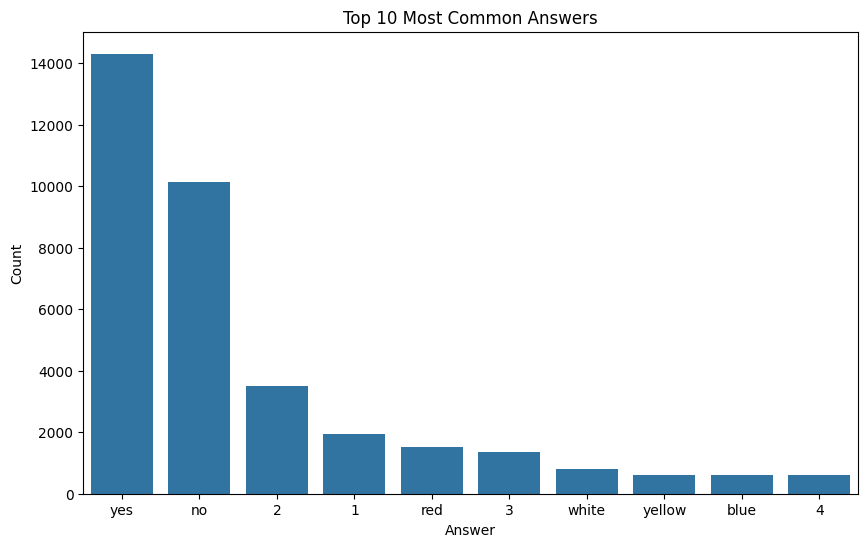

In [ ]:
# Perform EDA
print("Number of questions:", len(df_train["question_id"]))
print("Number of answers:", len(df_train["multiple_choice_answer"]))

answer_counts = df_train['multiple_choice_answer'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_counts.index[:10], y=answer_counts.values[:10])
plt.title('Top 10 Most Common Answers')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.show()


In [ ]:
# Create list of Character count, Word count, First one word, First two words, and unique words of questions
char_count_que = []
word_count_que = []
first_word_que = []
two_word_que = []
unique_word_que = []

for q in df_train["question_preprocessed"]:
    char_count_que.append(len(q))
    word_count_que.append(len(q.split()))
    first_word_que.append(q.split()[0].lower())
    two_word_que.append(" ".join(q.split()[:2]).lower())
    unique_word_que.extend(q.split())
unique_word_que = set(unique_word_que)

<ipython-input-119-8473a5f7c10e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count_que, color='red')
<ipython-input-119-8473a5f7c10e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count_que, color='red')


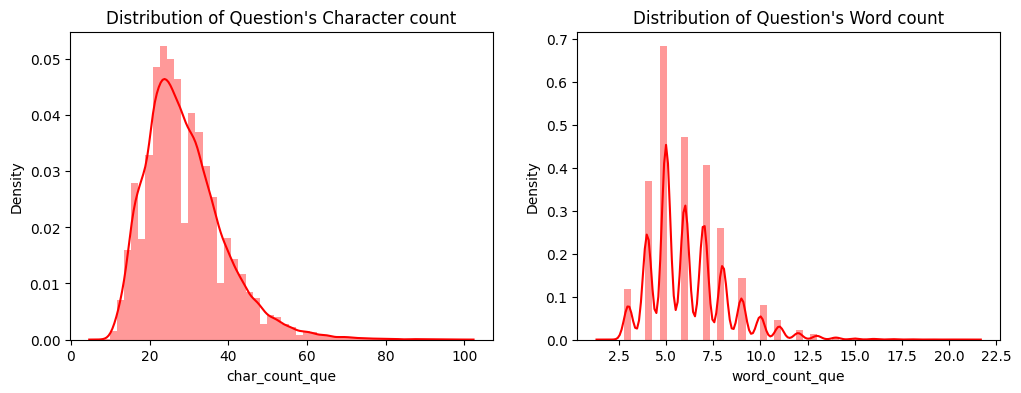

In [ ]:
# Plot Distribution of Character count, Word count of question
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_que, color='red')
plt.title('Distribution of Question\'s Character count')
plt.xlabel('char_count_que')
plt.subplot(1,2,2)
sns.distplot(word_count_que, color='red')
plt.title('Distribution of Question\'s Word count')
plt.xlabel('word_count_que')
plt.show()

In [ ]:
# Percentile of word_count_que
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")

0th percentile 2.0
10th percentile 4.0
20th percentile 5.0
30th percentile 5.0
40th percentile 5.0
50th percentile 6.0
60th percentile 6.0
70th percentile 7.0
80th percentile 8.0
90th percentile 9.0
100th percentile 21.0
-------------------------
91th percentile 9.0
92th percentile 9.0
93th percentile 9.0
94th percentile 10.0
95th percentile 10.0
96th percentile 10.0
97th percentile 11.0
98th percentile 11.0
99th percentile 13.0
100th percentile 21.0


In [ ]:
print("The maximum character length of Question:", max(char_count_que))
print("The minimum character length of Question:", min(char_count_que))
print('The average character length of Question:',int(sum(char_count_que)/len(char_count_que)))
print('-'*50)
print("The maximum word length of Question:", max(word_count_que))
print("The minimum word length of Question:", min(word_count_que))
print('The average word length of Question:',int(sum(word_count_que)/len(word_count_que)))
print('-'*50)
print('Total unique words in questions:',len(unique_word_que))

The maximum character length of Question: 99
The minimum character length of Question: 8
The average character length of Question: 28
--------------------------------------------------
The maximum word length of Question: 21
The minimum word length of Question: 2
The average word length of Question: 6
--------------------------------------------------
Total unique words in questions: 4511


In [ ]:
print('Types of questions as per given question_type:',len(set(df_train["question_type"])))
print('Types of questions as per first one word of question:',len(set(first_word_que)))
print('Types of questions as per first two word of question:',len(set(two_word_que)))

# Create dataframe of First one word of question and its question count
count = {}
for i in first_word_que:
    count[i] = count.get(i, 0) + 1

first_word_que_df = pd.DataFrame(list(count.items()),columns=["first_word","question_count"])
first_word_que_df["question_%"] = first_word_que_df["question_count"]/len(first_word_que)*100
first_word_que_df = first_word_que_df.sort_values(by='question_count',ascending=False)
first_word_que_df.head(5)

Types of questions as per given question_type: 81
Types of questions as per first one word of question: 80
Types of questions as per first two word of question: 1068


,first_word,question_count,question_%
3,what,19909,33.181667
2,is,16276,27.126667
4,how,9026,15.043333
7,are,4480,7.466667
1,where,3139,5.231667


In [ ]:
# Create dataframe of First two words of question and its question count
count = {}
for i in two_word_que:
    count[i] = count.get(i, 0) + 1

two_word_que_df = pd.DataFrame(list(count.items()),columns=["two_word","question_count"])
two_word_que_df["question_%"] = two_word_que_df["question_count"]/len(first_word_que)*100
two_word_que_df = two_word_que_df.sort_values(by='question_count',ascending=False)
two_word_que_df.head(10)

,two_word,question_count,question_%
11,is the,11010,18.350000
8,what is,9761,16.268333
15,how many,8493,14.155000
4,what color,5356,8.926667
1,where is,2687,4.478333
16,is there,2113,3.521667
23,are the,1998,3.330000
21,does the,1406,2.343333
24,what are,992,1.653333
30,are there,934,1.556667


3.3 EDA - Answers

In [ ]:
# Create list of Character count, Word count, and unique words of answers
char_count_ans = []
word_count_ans = []
for a in (df_train["answer_preprocessed"]):
    char_count_ans.append(len(a))
    word_count_ans.append(len(a.split()))

unique_ans = set(df_train["answer_preprocessed"])

<ipython-input-132-346a13c6e4c9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count_ans, color='red')
<ipython-input-132-346a13c6e4c9>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count_ans, color='red')


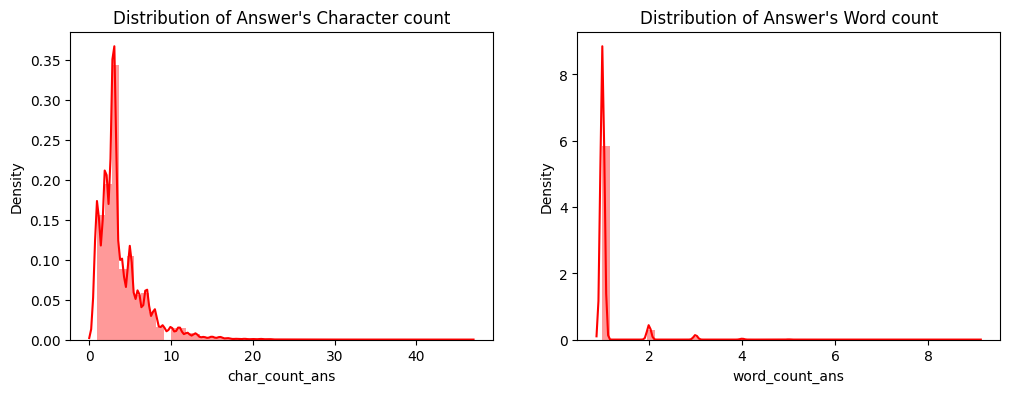

In [ ]:
# Plot Distribution of Character count, Word count of answers
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_ans, color='red')
plt.title('Distribution of Answer\'s Character count')
plt.xlabel('char_count_ans')
plt.subplot(1,2,2)
sns.distplot(word_count_ans, color='red')
plt.title('Distribution of Answer\'s Word count')
plt.xlabel('word_count_ans')
plt.show()

In [ ]:
# Percentile of word_count_ans
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")

0th percentile 1.0
10th percentile 1.0
20th percentile 1.0
30th percentile 1.0
40th percentile 1.0
50th percentile 1.0
60th percentile 1.0
70th percentile 1.0
80th percentile 1.0
90th percentile 1.0
100th percentile 9.0
-------------------------
91th percentile 1.0
92th percentile 1.0
93th percentile 1.0
94th percentile 2.0
95th percentile 2.0
96th percentile 2.0
97th percentile 2.0
98th percentile 2.0
99th percentile 3.0
100th percentile 9.0


In [ ]:
print("The maximum character length of Answer:", max(char_count_ans))
print("The minimum character length of Answer:", min(char_count_ans))
print('The average character length of Answer:',int(sum(char_count_ans)/len(char_count_ans)))
print('-'*50)
print("The maximum word length of Answer:", max(word_count_ans))
print("The minimum word length of Answer:", min(word_count_ans))
print('The average word length of Answer:',int(sum(word_count_ans)/len(word_count_ans)))
print('-'*50)
print('Total number of unique Answers:',len(unique_ans))
print('Types of Answers as per given answer_type:',len(set(df_train["answer_type"])))

The maximum character length of Answer: 46
The minimum character length of Answer: 1
The average character length of Answer: 3
--------------------------------------------------
The maximum word length of Answer: 9
The minimum word length of Answer: 1
The average word length of Answer: 1
--------------------------------------------------
Total number of unique Answers: 2508
Types of Answers as per given answer_type: 3


In [ ]:
# create dataframe of answer_type and its counts
answer_type_df = (df_train.groupby(['answer_type']).count()['answers']).to_frame()
answer_type_df['answer%'] = round(answer_type_df['answers'] / len(df_train["answer_type"]) * 100,2)
answer_type_df = answer_type_df.sort_values(by='answers',ascending=False)
answer_type_df

,answers,answer%
answer_type,,
other,26916,44.86
yes/no,24396,40.66
number,8688,14.48


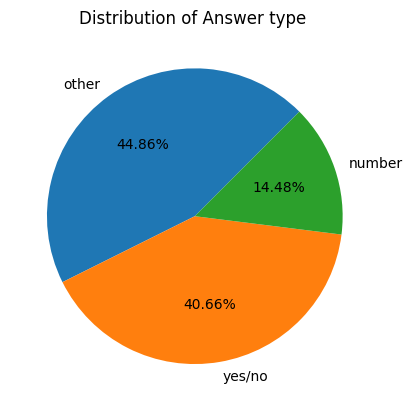

In [ ]:
# plot pie chart of dataframe of answer_type and its counts
plt.pie(list(answer_type_df['answer%']), labels=list(answer_type_df.index), autopct='%1.2f%%', startangle=45)
plt.title('Distribution of Answer type ')
plt.show()

In [ ]:
# create dataframe of unique answers and its counts in decending order of answer_count
count = {}
for i in df_train["answer_preprocessed"]:
    count[i] = count.get(i, 0) + 1

answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(df_train["answer_preprocessed"])*100
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(10)

,answer,answer_count,answer%
3,yes,14314,23.856667
7,no,10143,16.905000
15,2,3496,5.826667
16,1,1934,3.223333
32,red,1506,2.510000
20,3,1373,2.288333
107,white,789,1.315000
33,yellow,603,1.005000
34,blue,603,1.005000
70,4,599,0.998333


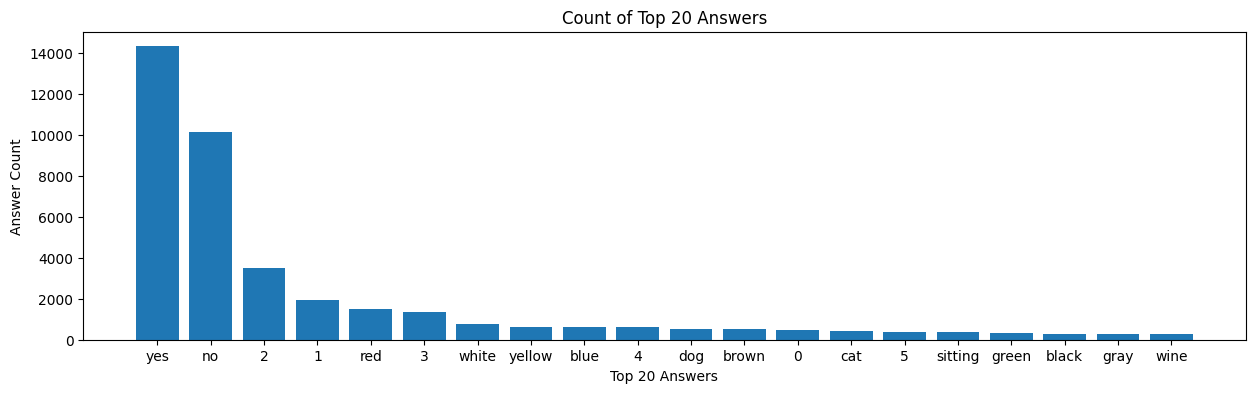

In [ ]:
# Plot top 20 answers and its count from above dataframe
plt.figure(figsize=(15,4))
plt.bar(list(answer_df['answer'])[:20], list(answer_df['answer_count'])[:20])
plt.title('Count of Top 20 Answers')
plt.xlabel('Top 20 Answers')
plt.ylabel('Answer Count')
plt.xticks(list(answer_df['answer'])[:20])
plt.show()

In [ ]:
print(f"Top 1000 answers coverd {round(sum(list(answer_df['answer%'][:1000])),2)}% of datapoints")
print(f"Top 2000 answers coverd {round(sum(list(answer_df['answer%'][:2000])),2)}% of datapoints")
print(f"Top 3000 answers coverd {round(sum(list(answer_df['answer%'][:3000])),2)}% of datapoints")

Top 1000 answers coverd 97.46% of datapoints
Top 2000 answers coverd 99.15% of datapoints
Top 3000 answers coverd 100.0% of datapoints


3.4 EDA -Question & Answers

In [ ]:
# Create dataframe of first two words of question and its most common answers
question_df = pd.DataFrame(question_preprocessed,columns=["question"])
question_split_df = question_df['question'].str.split(" ", expand = True)
question_answer_df = question_split_df.iloc[:,:-20]
question_answer_df['answer'] = answer

def que_ans_analysis2(word_1,word_2):
    word_1_2_df = question_answer_df[(question_answer_df[0] == word_1) & (question_answer_df[1] == word_2)]
    word_1_2_count = (word_1_2_df.groupby(['answer']).count()[0]).to_frame()
    word_1_2_count = word_1_2_count.sort_values(by=0,ascending=False)

    plt.figure(figsize=(20,4))
    plt.bar(list(word_1_2_count.index)[:20], list(word_1_2_count[0])[:20])
    plt.title('Count of Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.xlabel('Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.ylabel('Count')
    plt.xticks(list(word_1_2_count.index)[:20])
    plt.show()

In [ ]:
# Answer preprocessing

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_answers = label_encoder.fit_transform(train_annotations['multiple_choice_answer'])


In [ ]:
# Load validation questions

# Define the questions file
val_questions_file = os.path.join(data_path, 'val2015/MultipleChoice_abstract_v002_val2015_questions.json')
val_questions_feature = 'questions'

val_questions = load_data(val_questions_file, val_questions_feature )

# Check the first 5 rows
val_questions.head(5)

File not found: /content/drive/My Drive/Colab Notebooks/val2015/MultipleChoice_abstract_v002_val2015_questions.json


UnboundLocalError: local variable 'data' referenced before assignment

In [ ]:
# Load validation annotations

# Define the annotations file
val_annotations_file = os.path.join(data_path, 'val2015/abstract_v002_val2015_annotations.json')
val_annotations_feature = 'annotations'
val_annotations = load_data(val_annotations_file, val_annotations_feature)

# Check the first 5 rows
val_annotations.head(5)

File not found: /content/drive/My Drive/Colab Notebooks/val2015/abstract_v002_val2015_annotations.json


UnboundLocalError: local variable 'data' referenced before assignment

In [ ]:
# Define VQA Model architecture

import tensorflow as tf
from tensorflow import keras
from keras.src.models.model import Model
from keras.src.layers.rnn.lstm import LSTM
from keras.src.layers.reshaping.flatten import Flatten
from keras.src.layers.pooling.max_pooling2d import MaxPooling2D
from keras.src.layers.merging.concatenate import Concatenate
from keras.src.layers.core.input_layer import Input
from keras.src.layers.core.embedding import Embedding
from keras.src.layers.core.dense import Dense
from keras.src.layers.convolutional.conv2d import Conv2D

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten Embedding, LSTM, Dense, Concatenate

# Image model
image_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_model = Model(inputs=image_input, outputs=x)

# Question model
question_input = Input(shape=(None,))
y = Embedding(input_dim=10000, output_dim=256)(question_input)
y = LSTM(256)(y)
question_model = Model(inputs=question_input, outputs=y)

# Combine models
combined = Concatenate()([image_model.output, question_model.output])
z = Dense(256, activation='relu')(combined)
z = Dense(1000, activation='softmax')(z)

vqa_model = Model(inputs=[image_model.input, question_model.input], outputs=z)
vqa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the Model

# image_data, question_data, and labels

vqa_model.fit([image_data, question_data], labels, epochs=10, batch_size=32, validation_data=([val_image_data, val_question_data], val_labels))



In [ ]:
# Evaluate the Model
loss, accuracy = vqa_model.evaluate([val_image_data, val_question_data], val_labels)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
